# Let's import a bunch of stuff

In [1]:
import sys
import seaborn as sns
import scanpy.external as sce
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import argparse
import gc
%matplotlib inline

# Import data and subset to be able to run locally

In [2]:
adata = sc.read('CLUESImmVarMonoDC.V6.h5ad', cache=True)
print(adata)
sc.pp.subsample(adata,fraction=0.05)
print(adata)
print(adata.obs['ct_cov'].unique())

AnnData object with n_obs × n_vars = 238293 × 1829 
    obs: 'disease_cov', 'ct_cov', 'pop_cov', 'ind_cov', 'well', 'batch_cov', 'batch', 'percent_mito', 'n_counts', 'SLEDAI', 'Broad', 'Female', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'PC2', 'PC3', 'louvain', 'leiden'
    var: 'gene_ids-0-0-0-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0', 'gene_ids-1-0-0-0-0', 'gene_ids-1-0-0-0', 'gene_ids-1-0-0', 'gene_ids-1-0', 'gene_ids-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'leiden', 'louvain', 'neighbors', 'pca', 'raw_counts'
    obsm: 'X_pca', 'X_diffmap', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 11914 × 1829 
    obs: 'disease_cov', 'ct_cov', 'pop_cov', 'ind_cov', 'well', 'batch_cov', 'batch', 'percent_mito', 'n

# Sample feature plots

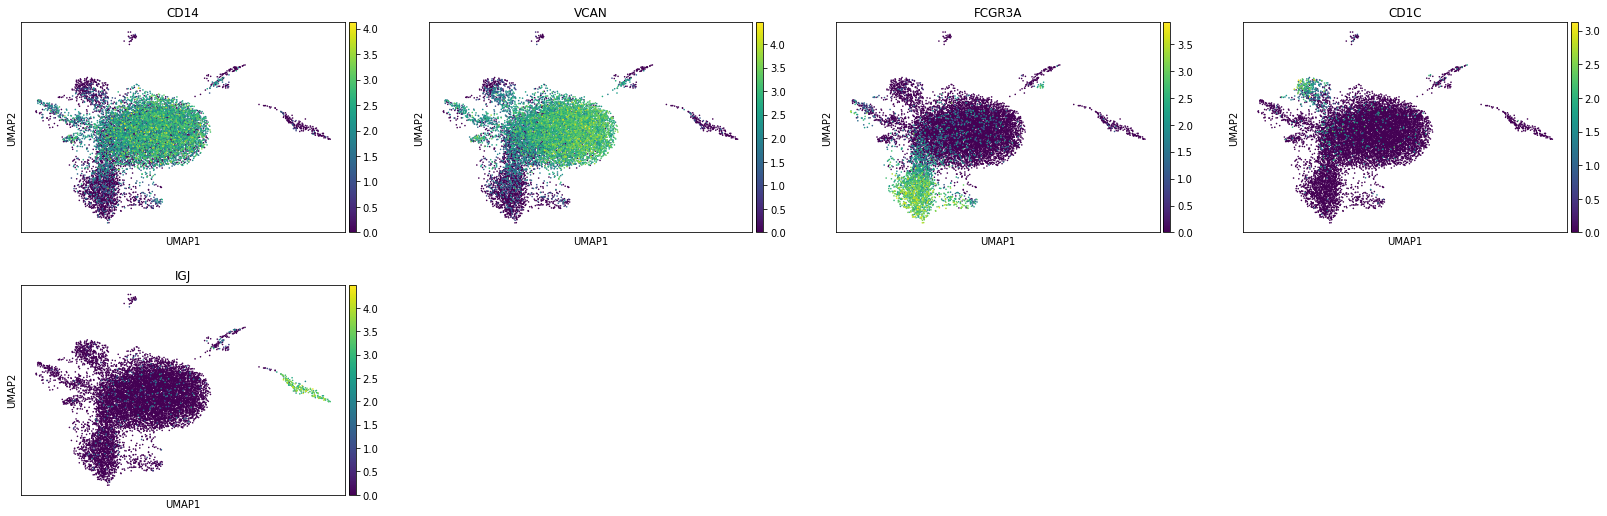

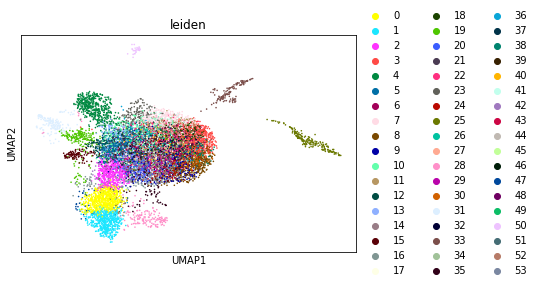

In [3]:
#sc.tl.leiden(adata)
sc.pl.umap(adata, color=['CD14', 'VCAN', 'FCGR3A', 'CD1C', 'IGJ'])
sc.pl.umap(adata,color='leiden')

In [4]:
#get visualization of all markers and their scores
#sc.tl.rank_genes_groups(adata, groupby='leiden')
#sc.pl.rank_genes_groups(adata)

# Palantir trajectory

In [5]:
sns.set(font_scale=1.25)
sc.settings.set_figure_params(dpi_save=250, format='png', transparent=True)
color_map = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2',
    '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
    '#c5b0d5', '#c49c94', '#f7b6d2',
    '#dbdb8d', '#9edae5',
    '#ad494a', '#8c6d31']
n_bins = 20
print(adata)
# Keep only memory and naive CD4s
adata = adata[adata.obs['ct_cov'].isin(['cM','ncM'])]
print(adata)
d = sce.tl.palantir(adata)
# Do not filter again! Pass preprocessed data only
d.filter_low = False
d.normalize = False
d.log_transform = False
d.process()
clusters = d.palantir.utils.determine_cell_clusters(d.pca_projections)

AnnData object with n_obs × n_vars = 11914 × 1829 
    obs: 'disease_cov', 'ct_cov', 'pop_cov', 'ind_cov', 'well', 'batch_cov', 'batch', 'percent_mito', 'n_counts', 'SLEDAI', 'Broad', 'Female', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'PC2', 'PC3', 'louvain', 'leiden'
    var: 'gene_ids-0-0-0-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0-0', 'gene_ids-1-0-0-0-0-0', 'gene_ids-1-0-0-0-0', 'gene_ids-1-0-0-0', 'gene_ids-1-0-0', 'gene_ids-1-0', 'gene_ids-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'leiden', 'louvain', 'neighbors', 'pca', 'raw_counts', 'leiden_colors'
    obsm: 'X_pca', 'X_diffmap', 'X_umap'
    varm: 'PCs'
View of AnnData object with n_obs × n_vars = 11202 × 1829 
    obs: 'disease_cov', 'ct_cov', 'pop_cov', 'ind_cov', 'well', 'batch_cov', 'ba

# Choose start cell for pseudotime

In [6]:
# This dictats the starting cell for pseudotime. I chose the cell with highest expression of a single marker gene
start_cell = np.argmax(d.data_df['VCAN']) # From what I am finding, the start cell does not really matter
pr_res = d.palantir.core.run_palantir(d.ms_data, start_cell, num_waypoints=500)

/Users/Perez/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Sampling and flocking waypoints...
Time for determining waypoints: 0.017273998260498045 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.39561575253804526 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9985
Correlation at iteration 2: 0.9998
Correlation at iteration 3: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


# Pseudotime Density plot

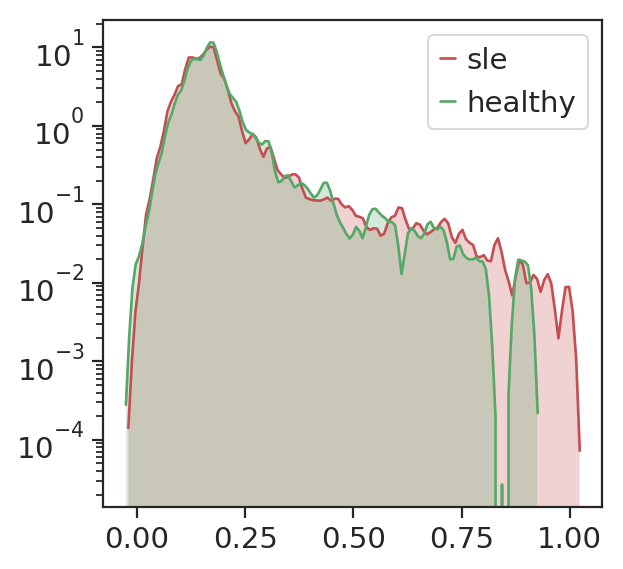

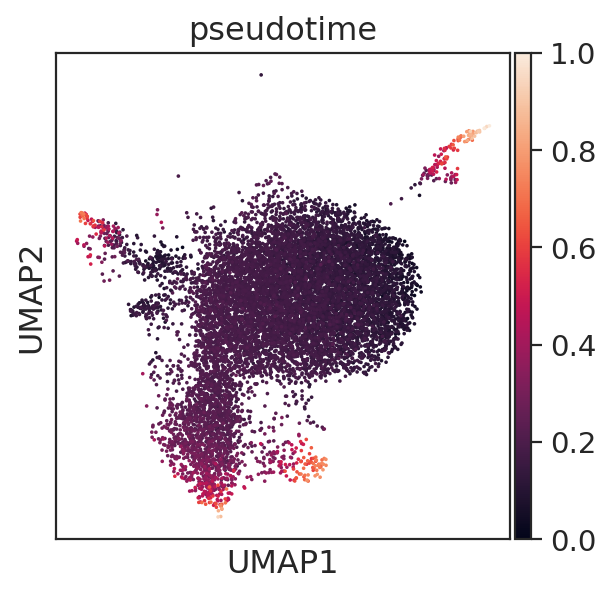

In [7]:
adata.obs['pseudotime']=pr_res.pseudotime.tolist()
sle = (adata.obs[adata.obs['disease_cov']=='sle']['pseudotime'].tolist())
healthy = (adata.obs[adata.obs['disease_cov']=='healthy']['pseudotime'].tolist())
ax = sns.kdeplot(sle, shade=True, color="r", label='sle')
ax = sns.kdeplot(healthy, shade=True, color="g", label='healthy')
ax.set_yscale('log')
ax.legend()
sc.pl.umap(adata, color='pseudotime')
# 0 is CD16, 1 is CD14, pDC, doublet etc

# Basic plotting plots

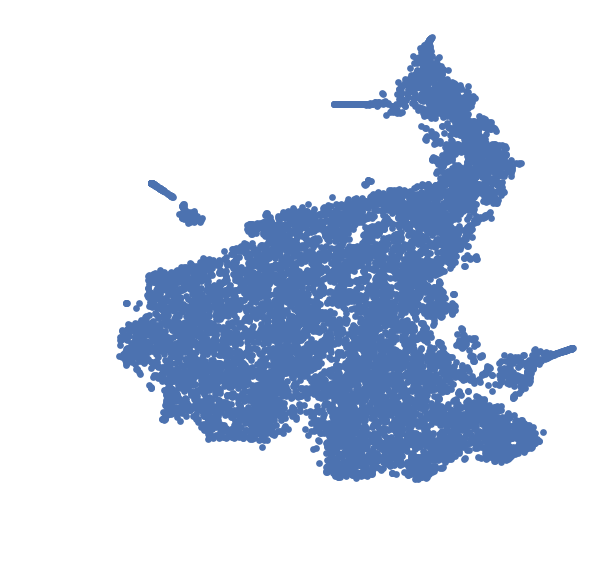

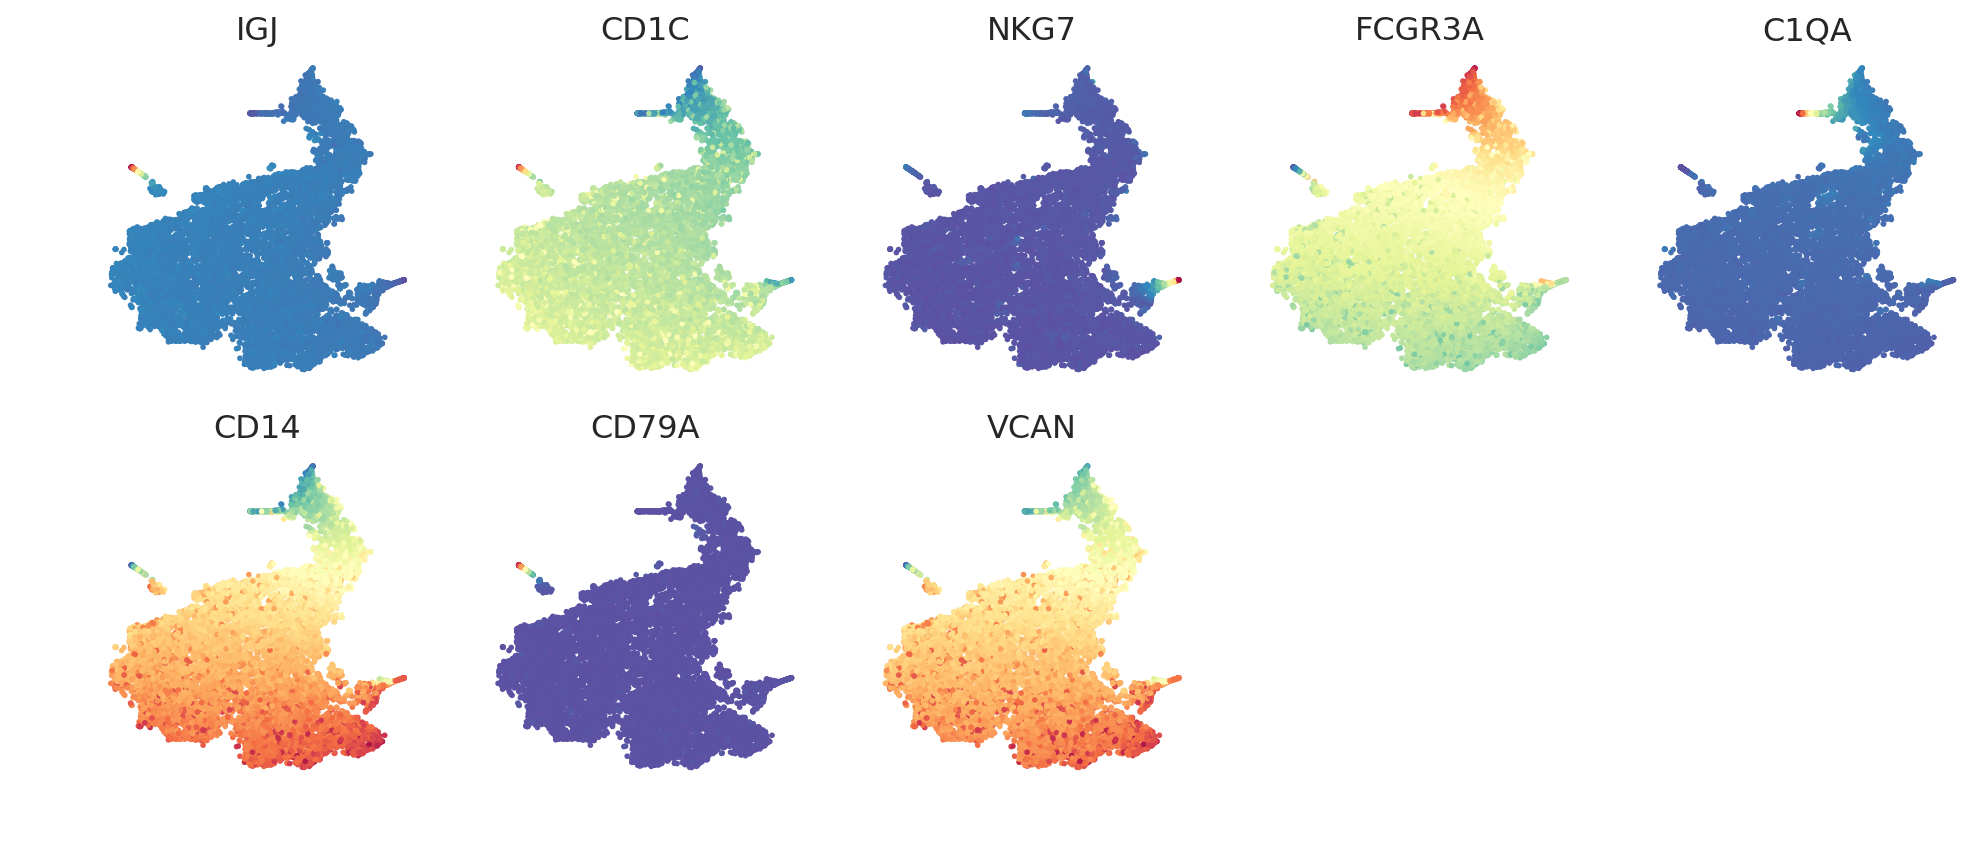

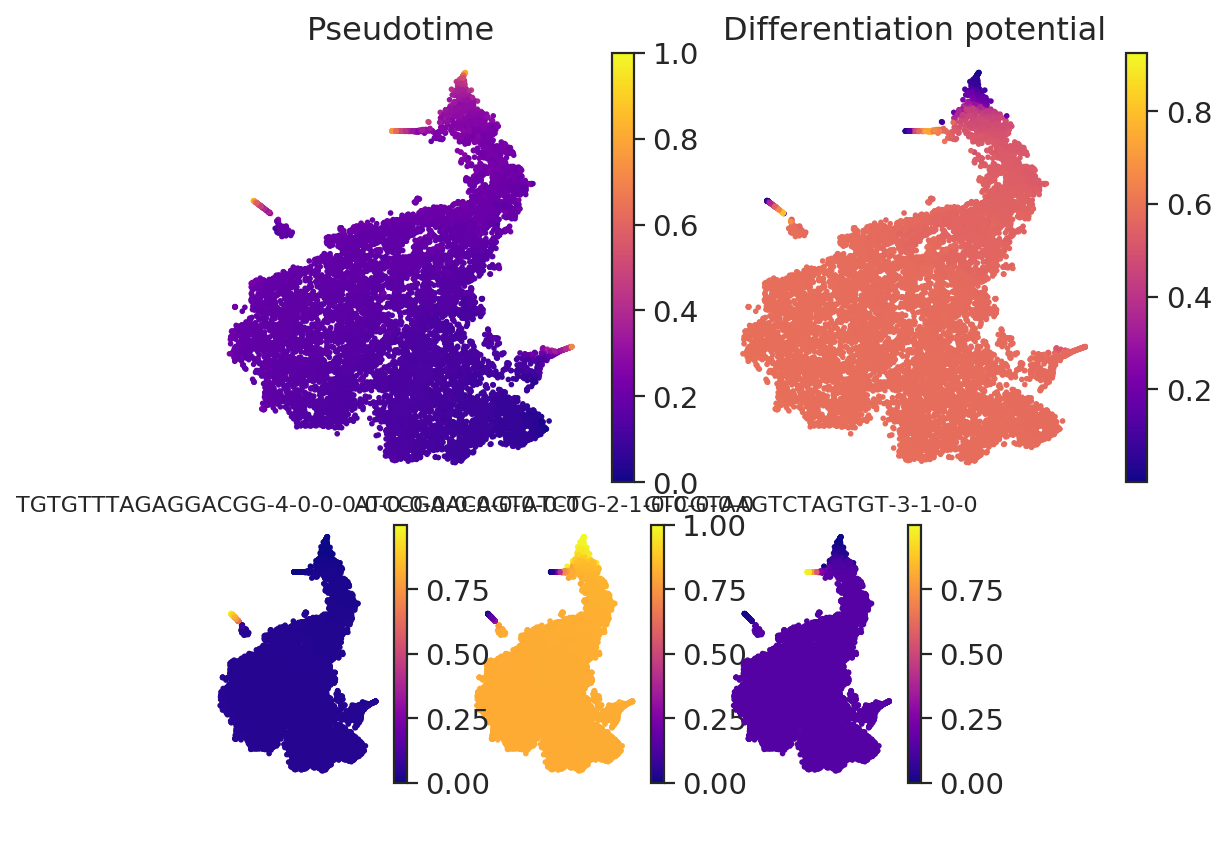

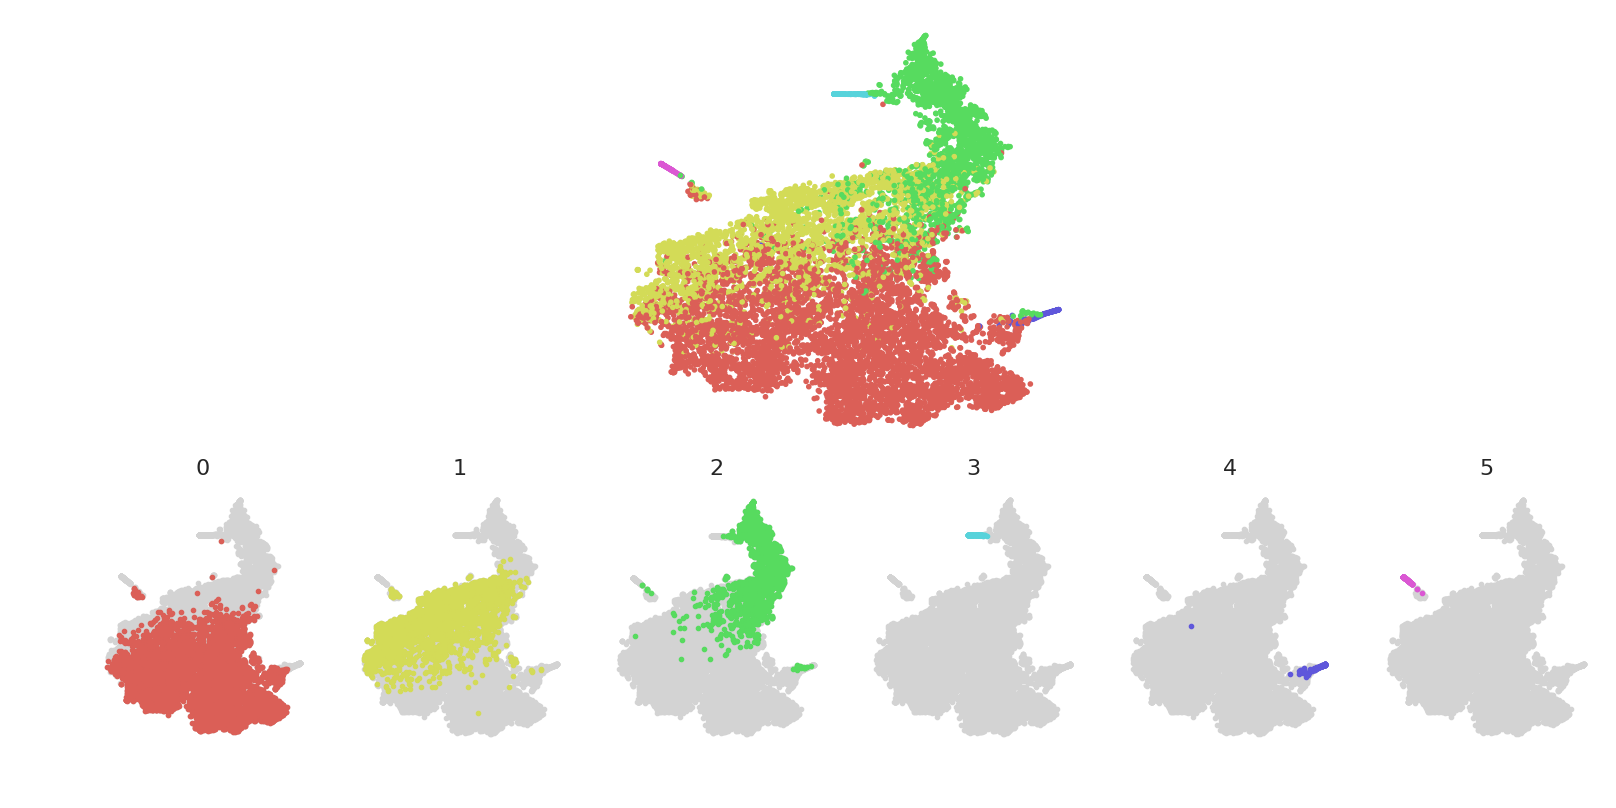

In [8]:
# Basic plots
fig, ax = d.palantir.plot.plot_tsne(d.tsne)
#fig, ax = d.palantir.plot.plot_tsne_by_cell_sizes(d.data_df, d.tsne)
genes = ['VCAN', 'CD14', 'FCGR3A', 'CD1C', 'IGJ', 'C1QA', 'CD79A', 'NKG7']
d.palantir.plot.plot_gene_expression(d.imp_df, d.tsne, genes)
d.palantir.plot.plot_palantir_results(pr_res, d.tsne)
d.palantir.plot.plot_cell_clusters(d.tsne, clusters)

# Check if clusters make sense

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

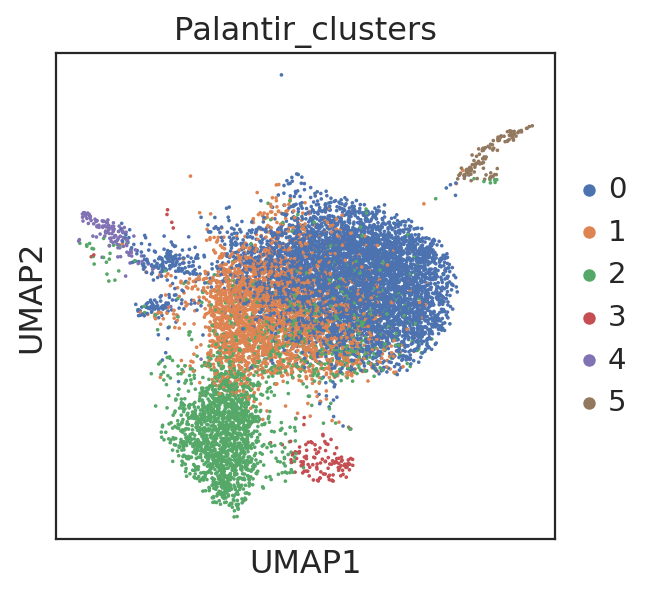

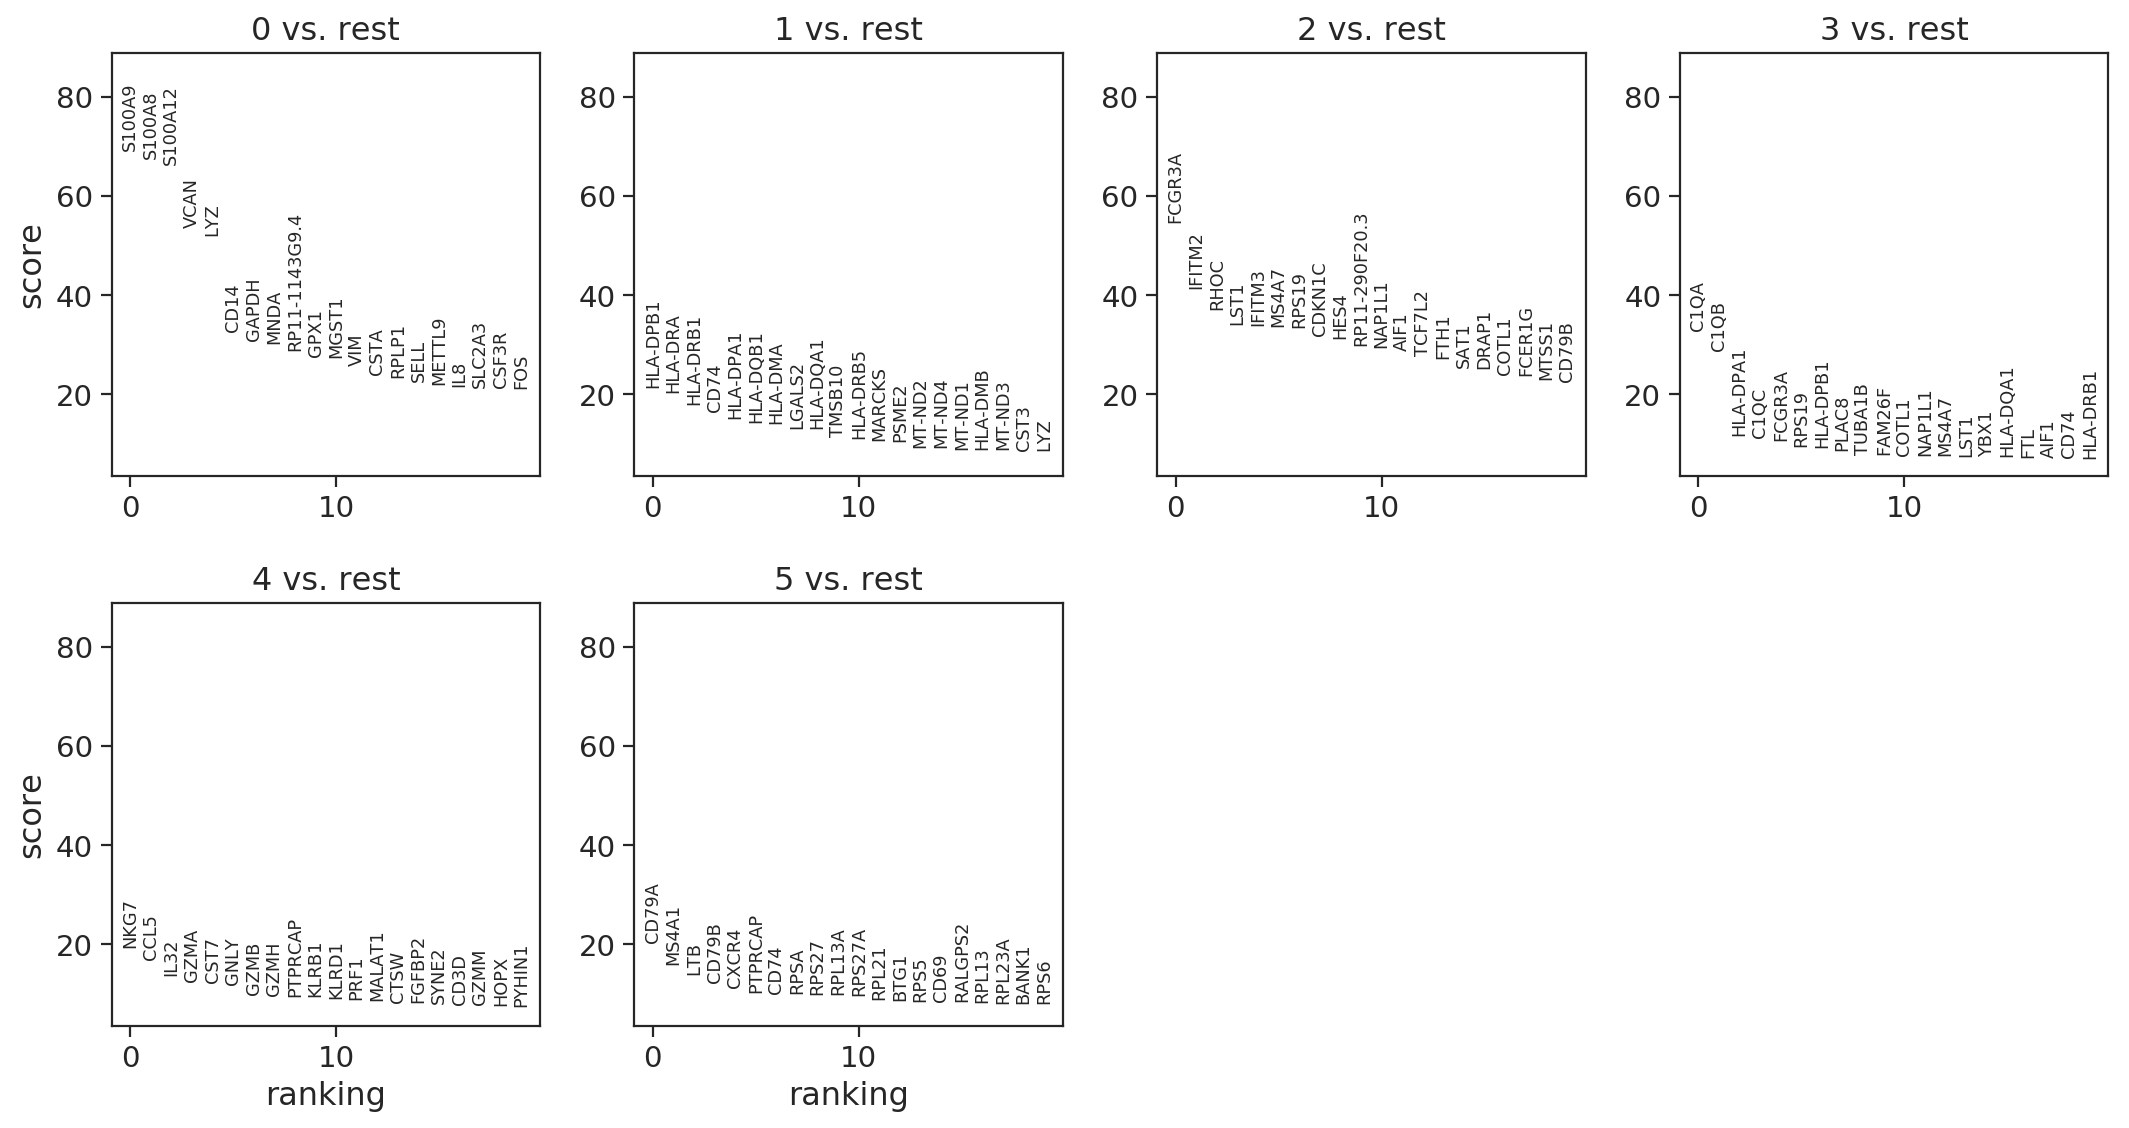

In [9]:
d.adata.obs['Palantir_clusters']=clusters.tolist()
d.adata.obs['Palantir_clusters'] = d.adata.obs['Palantir_clusters'].astype('category')
sc.pl.umap(d.adata, color='Palantir_clusters')
sc.tl.rank_genes_groups(d.adata, groupby='Palantir_clusters')
sc.pl.rank_genes_groups(d.adata)

# Remove doublets

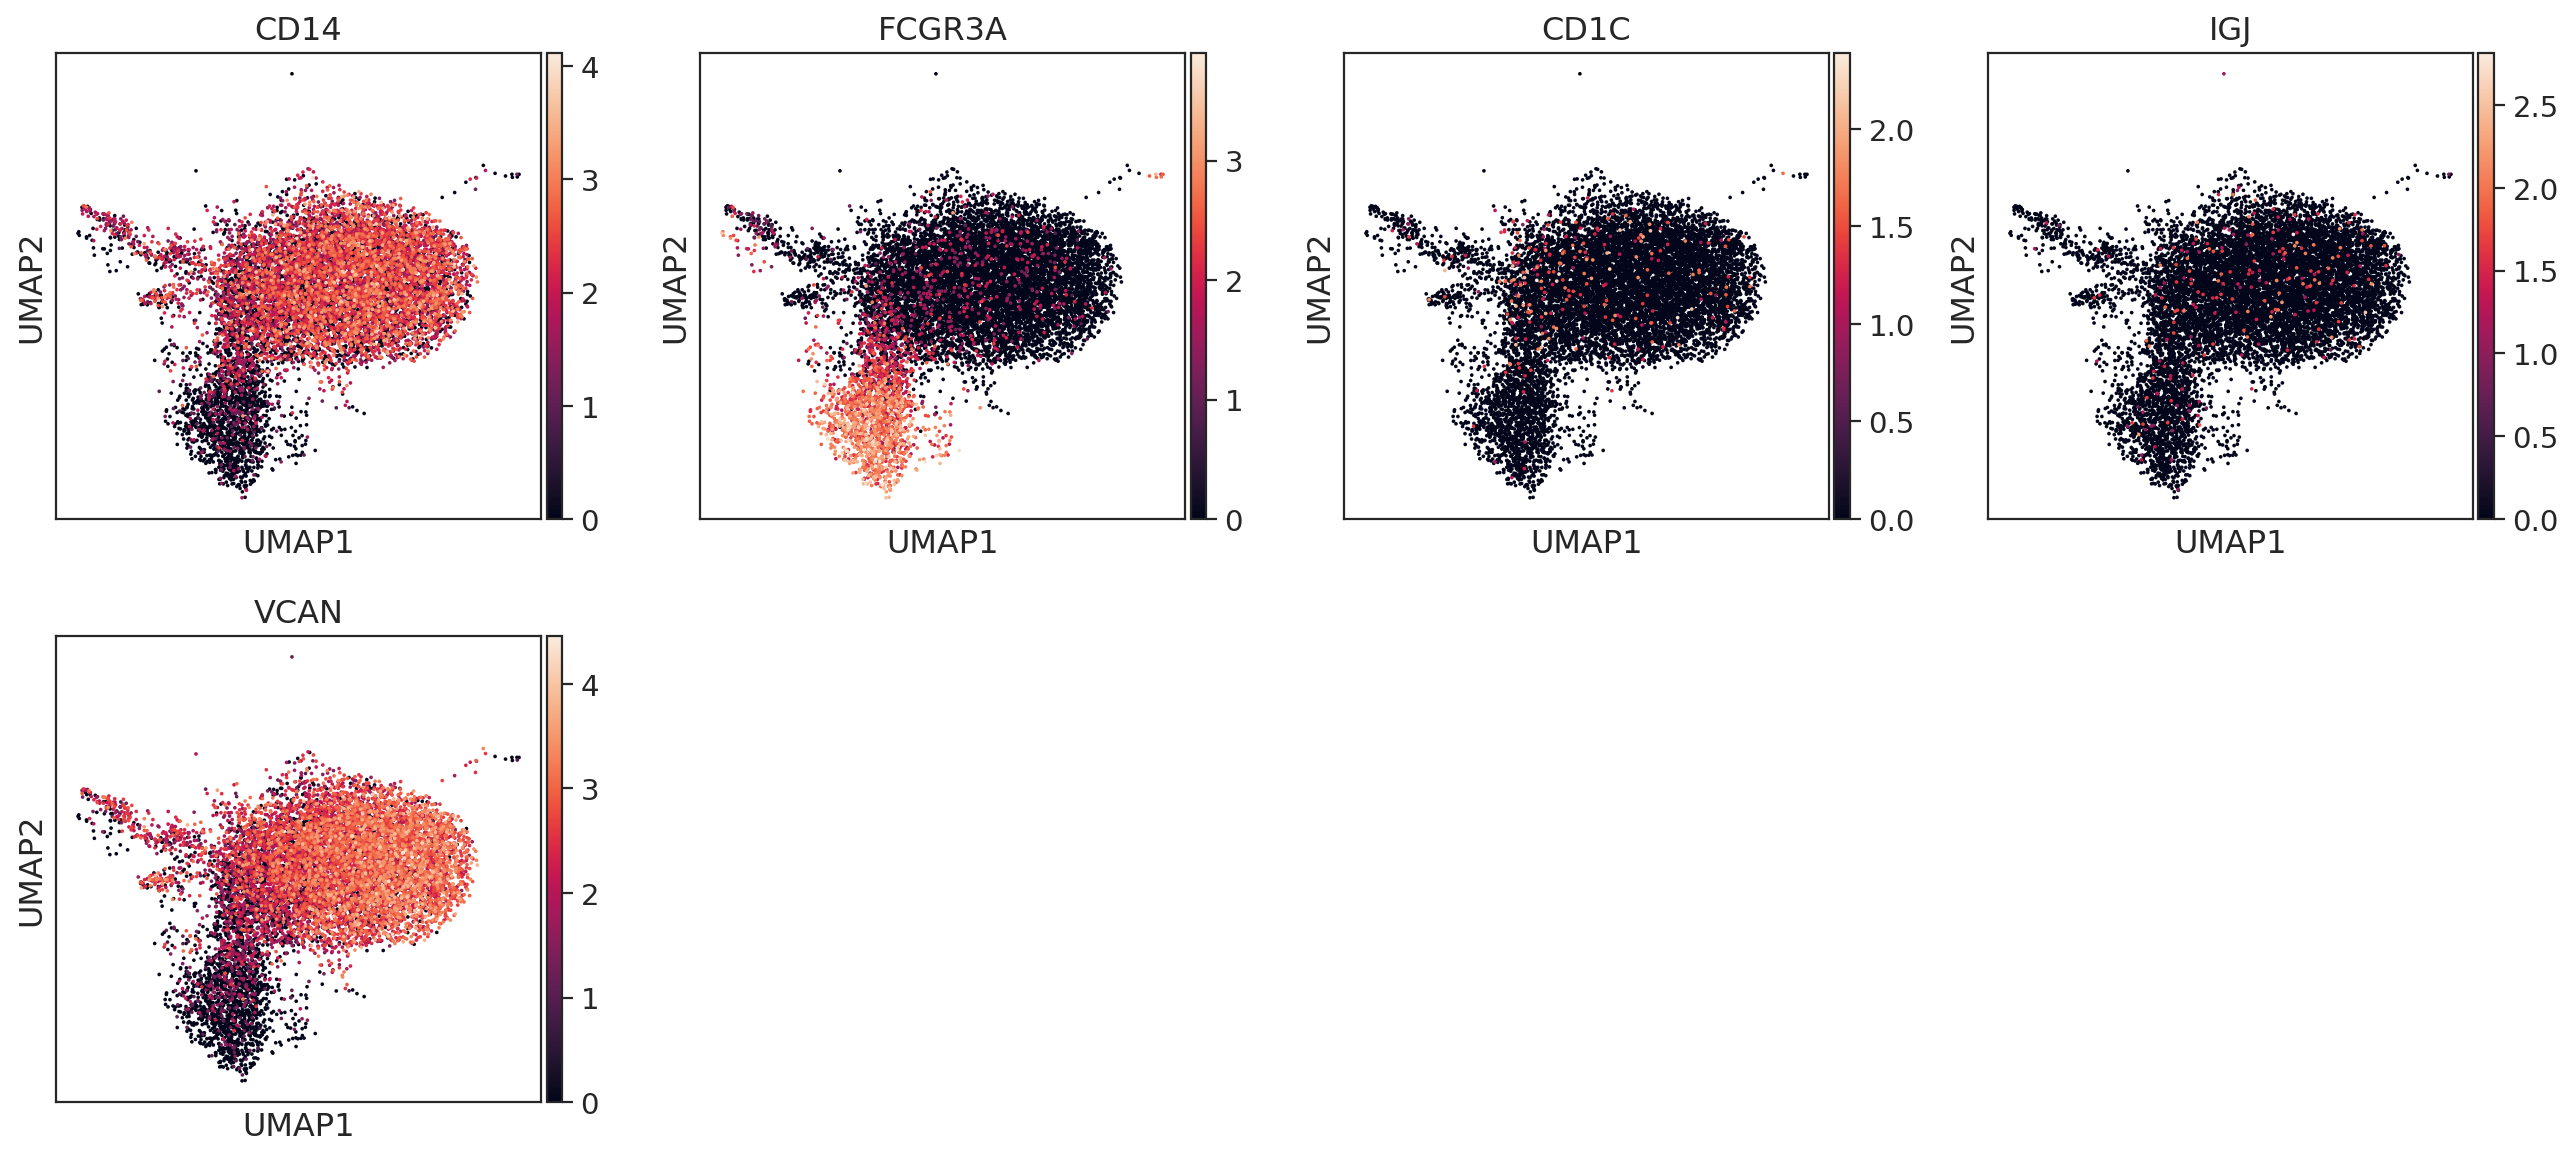

In [10]:
adata = d.adata[d.adata.obs['Palantir_clusters'].isin([0, 1, 2, 4])]
sc.pl.umap(adata, color=['CD14', 'FCGR3A', 'CD1C', 'IGJ', 'VCAN'])

# Rerun analysis and pseudotime

In [14]:
d = sce.tl.palantir(adata)
# Do not filter again! Pass preprocessed data only
d.filter_low = False
d.normalize = False
d.log_transform = False
d.process()
clusters = d.palantir.utils.determine_cell_clusters(d.pca_projections)
# This dictats the starting cell for pseudotime. I chose the cell with highest expression of a single marker gene
start_cell = np.argmax(d.data_df['FCGR3A']) # From what I am finding, the start cell does not really matter
pr_res = d.palantir.core.run_palantir(d.ms_data, start_cell, num_waypoints=500)

Determing nearest neighbor graph...
Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 46.509734869003296 seconds
Jaccard graph constructed in 9.469646215438843 seconds
Wrote graph to binary file in 4.101182222366333 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.280968
After 4 runs, maximum modularity is Q = 0.288141
Louvain completed 24 runs in 14.525063276290894 seconds
PhenoGraph complete in 74.76190781593323 seconds
Sampling and flocking waypoints...


/Users/Perez/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Time for determining waypoints: 0.02634191910425822 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.5816749135653178 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9894
Correlation at iteration 2: 0.9987
Correlation at iteration 3: 0.9995
Correlation at iteration 4: 0.9998
Correlation at iteration 5: 0.9998
Correlation at iteration 6: 0.9999
Correlation at iteration 7: 0.9999
Correlation at iteration 8: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


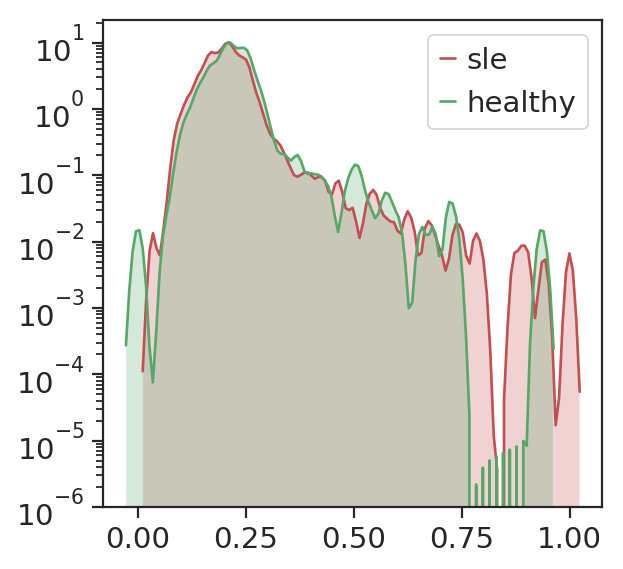

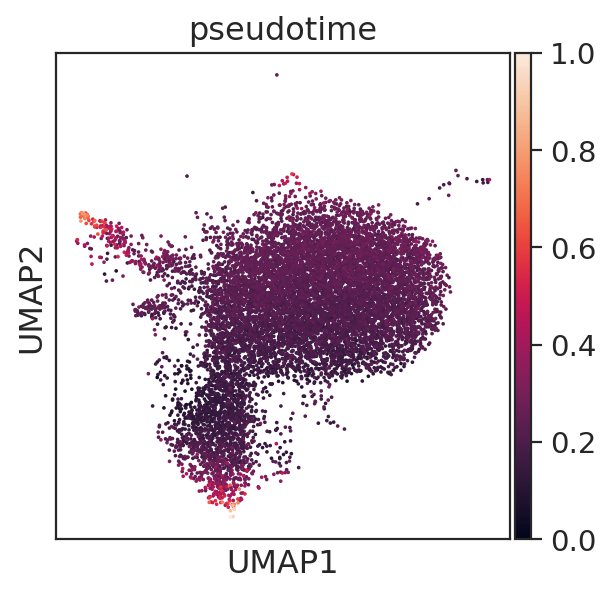

In [15]:
adata.obs['pseudotime']=pr_res.pseudotime.tolist()
sle = (adata.obs[adata.obs['disease_cov']=='sle']['pseudotime'].tolist())
healthy = (adata.obs[adata.obs['disease_cov']=='healthy']['pseudotime'].tolist())
ax = sns.kdeplot(sle, shade=True, color="r", label='sle')
ax = sns.kdeplot(healthy, shade=True, color="g", label='healthy')
ax.set_yscale('log')
ax.legend()
sc.pl.umap(adata, color='pseudotime')

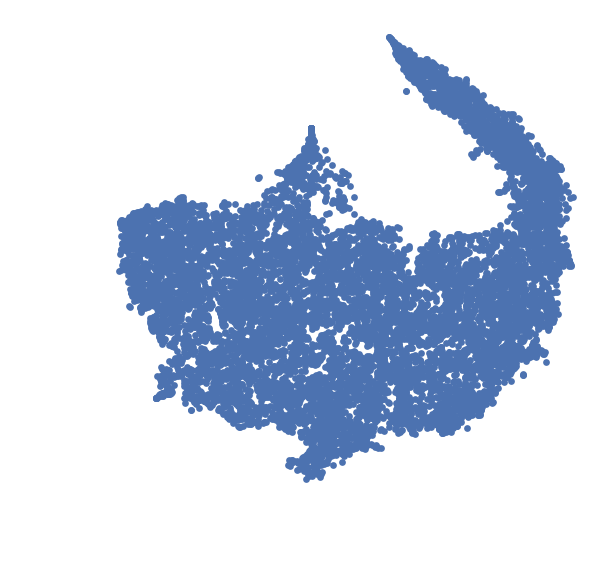

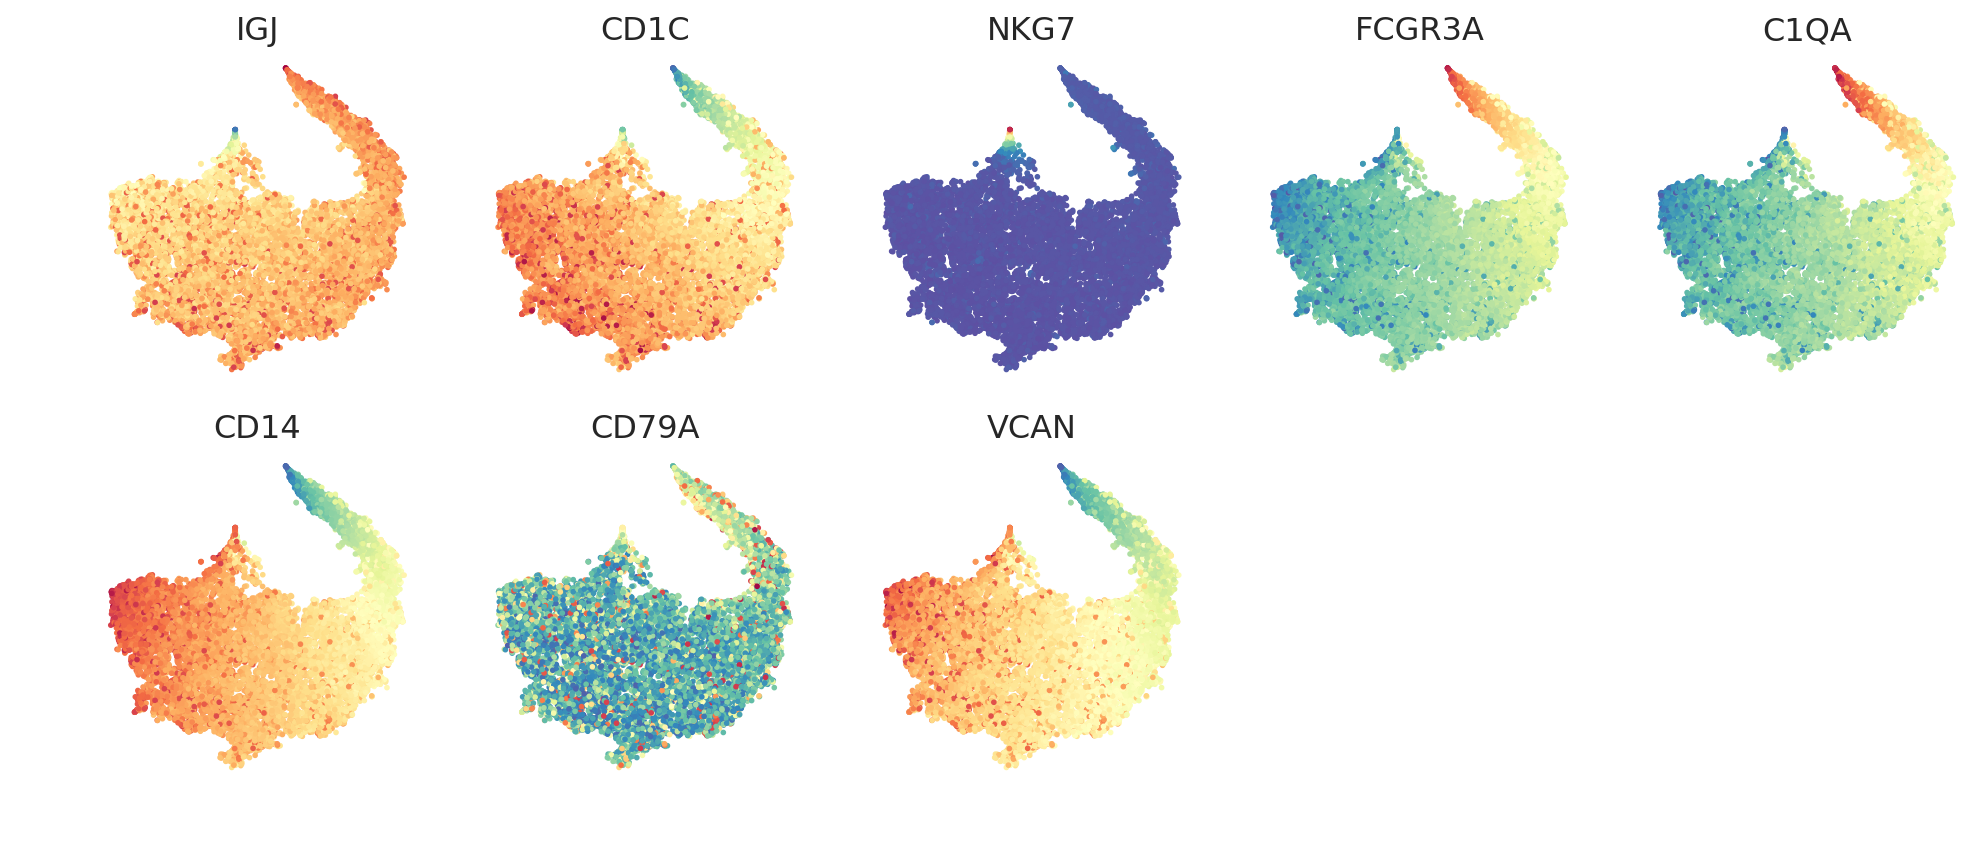

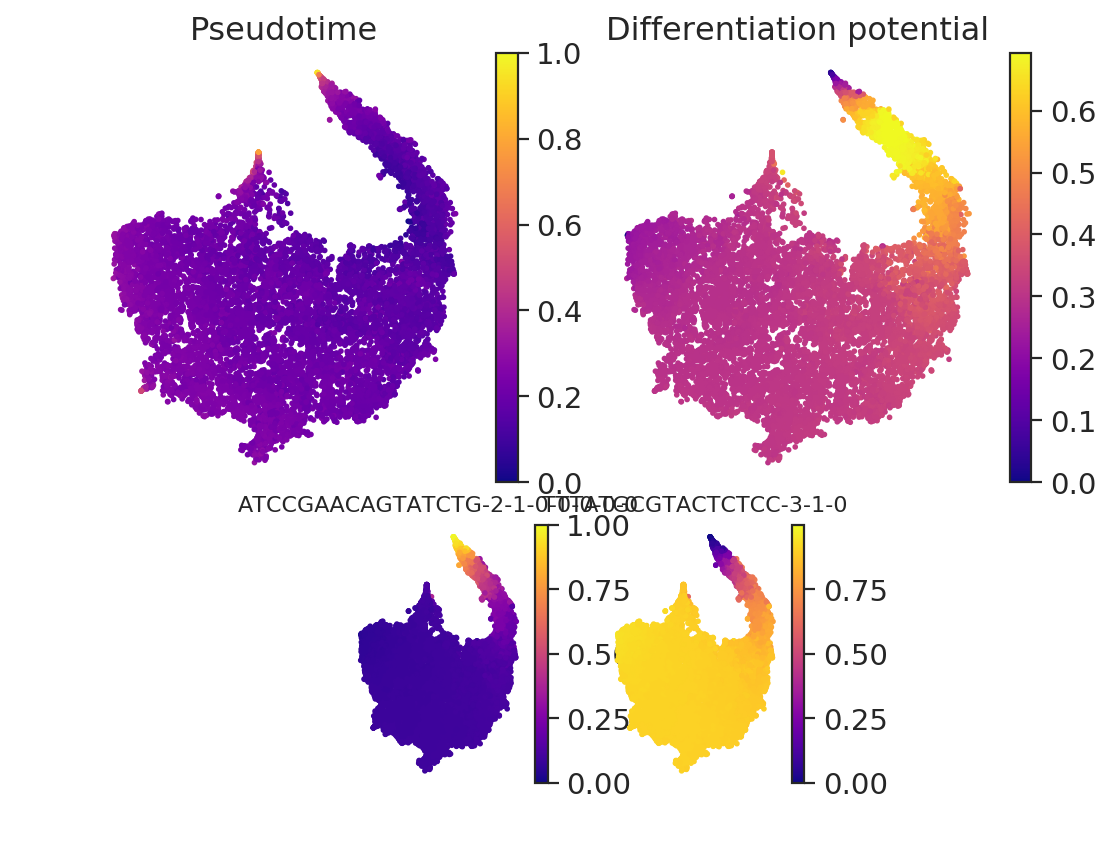

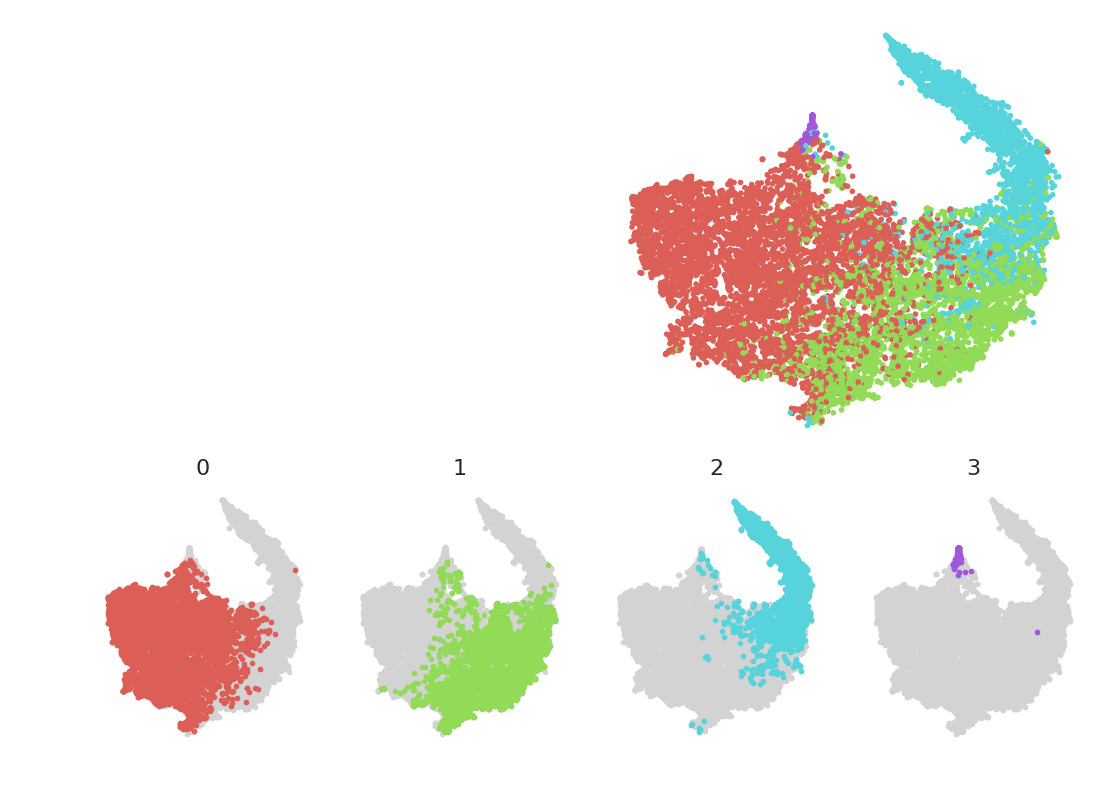

In [16]:
# Basic plots
fig, ax = d.palantir.plot.plot_tsne(d.tsne)
#fig, ax = d.palantir.plot.plot_tsne_by_cell_sizes(d.data_df, d.tsne)
genes = ['VCAN', 'CD14', 'FCGR3A', 'CD1C', 'IGJ', 'C1QA', 'CD79A', 'NKG7']
d.palantir.plot.plot_gene_expression(d.imp_df, d.tsne, genes)
d.palantir.plot.plot_palantir_results(pr_res, d.tsne)
d.palantir.plot.plot_cell_clusters(d.tsne, clusters)